In this notebook I will be adding derivatives models in python as I go through the book:
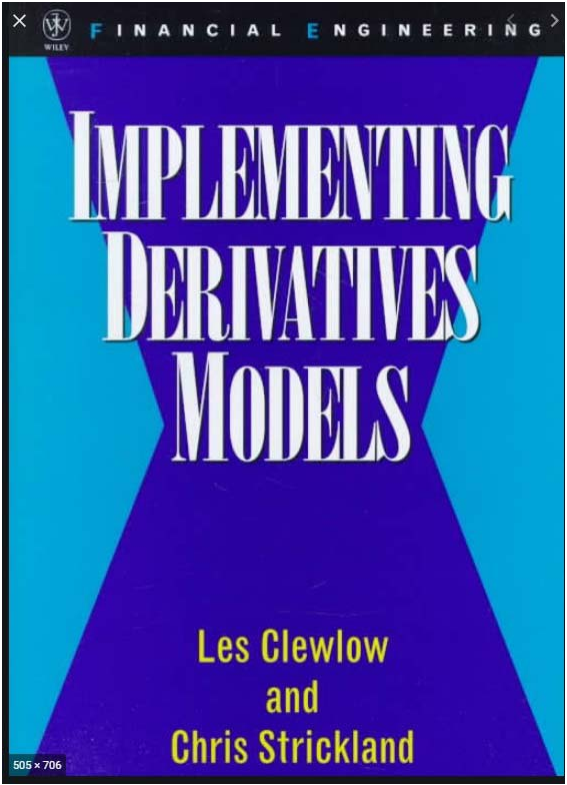

+
youtube https://www.youtube.com/@QuantPy
+google

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

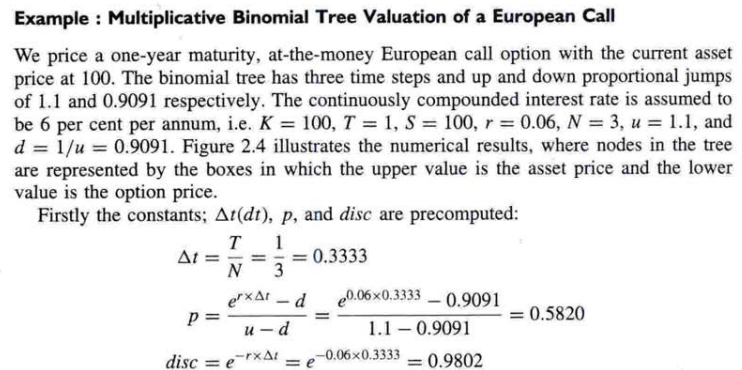
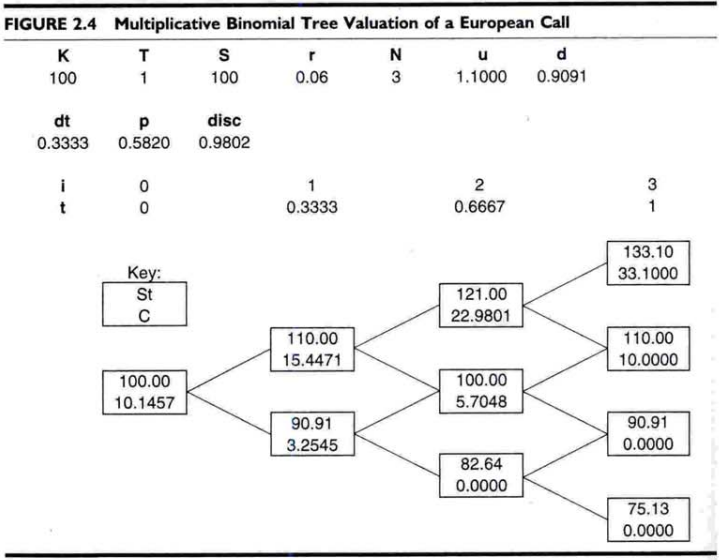

In [145]:
K = 100
S0 = 100
T = 1
r = 0.06
N = 3
u = 1.1
d = 1/u

In [149]:
def binomial_tree_EU_C(K,T,S0,r,N,u):
    
    # precompute constants
    d = 1/u
    dt = T/N
    p = (np.exp(r*dt) - d) / (u-d) #probabiltiy of UP
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d # S3,1 = S3,0 * (u/d) = 75.13 * u/d  -> S(3 steps,1 up)
                          # S3,2 = S3,0 * (u/d**2) -> S(3 steps 2 up)
                          # S3,3 = S3,0 * (u/d**3) -> S(3 steps,3 up)
                          # S2,0 = S0 * (d ** 2)
                          #...
                          # S1,0 = S0 * d
    # instead of the for loop: 
        # C = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1)) 
        
    # initialiase option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        C[j] = max(0, S[j] - K)
    # change for : C = np.maximum( C - K , np.zeros(N+1) )

    # step back through the tree
    for i in range(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( p*C[j+1] + (1-p)*C[j])
    # instead of the for loop:
    #for i in np.arange(N,0,-1):
    #   C = disc * ( q * C[1:i+1] + (1-q) * C[0:i] )
    return C[0]
binomial_tree_EU_C(K,T,S0,r,N,u)

10.145735799928817

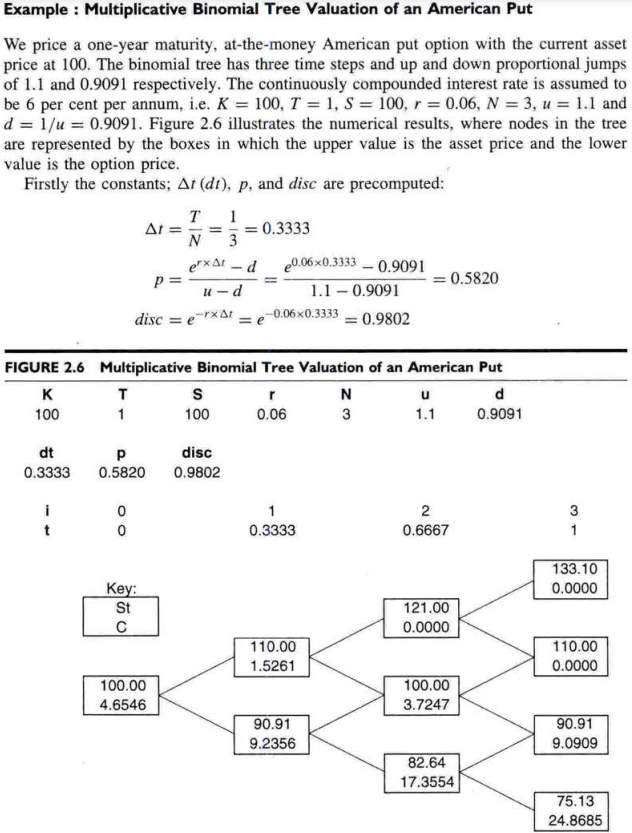

In [152]:
def binomial_tree_US_P(K,T,S0,r,N,u):
    
    # precompute constants
    d = 1/u
    dt = T/N
    p = (np.exp(r*dt) - d) / (u-d) #probabiltiy of UP
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N # S3,0 = S * (d ** N) = 100 * 0.9091**3 - 75.13
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d # S3,1 = S3,0 * (u/d) = 75.13 * u/d
                          # S3,2 = S3,0 * (u/d**2)
                          # S3,3 = S3,0 * (u/d**3)
                          # S2,0 = S0 * (d ** 2)
                          #...
                          # S1,0 = S0 * d
    # instead of the for loop: 
        # P = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1)) 
        
    # initialiase option values at maturity
    P = np.zeros(N+1)
    for j in range(0,N+1):
        P[j] = max(0,  K - S[j]) # CHANGE FROM EU CALL
    # change for : P = np.maximum( K - C , np.zeros(N+1) )

    # step back through the tree
    for i in range(N,0,-1):
        for j in range(0,i):
            P[j] = disc * ( p*P[j+1] + (1-p)*P[j])
            S[j] = S[j]/d # change from EU C
            P[j] = max(P[j], K - S[j]) # change from EU C
    # instead of the for loop:
    #for i in np.arange(N,0,-1):
    #   P = disc * ( q * P[1:i+1] + (1-q) * P[0:i] )
    return P[0]
binomial_tree_US_P(K,T,S0,r,N,u)

4.654588754602527

# MONTE CARLO
## Pseudo code for Monte Carlo valuation of a European Call Option in a Black Scholes World

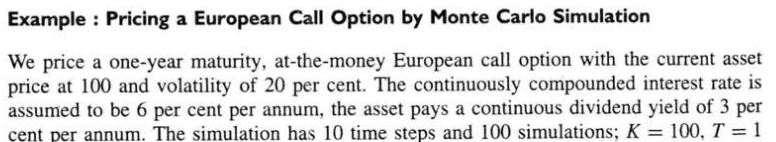
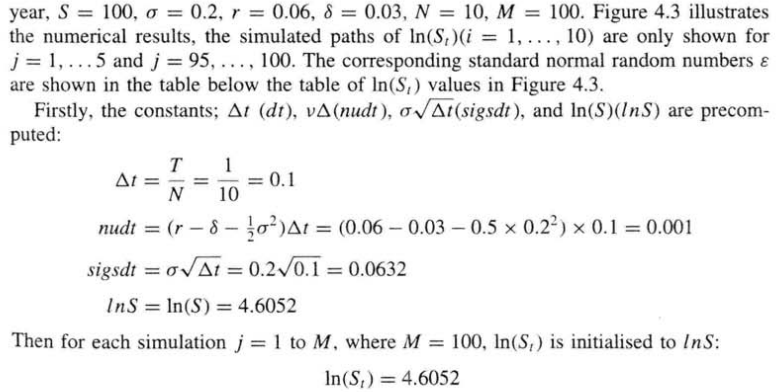
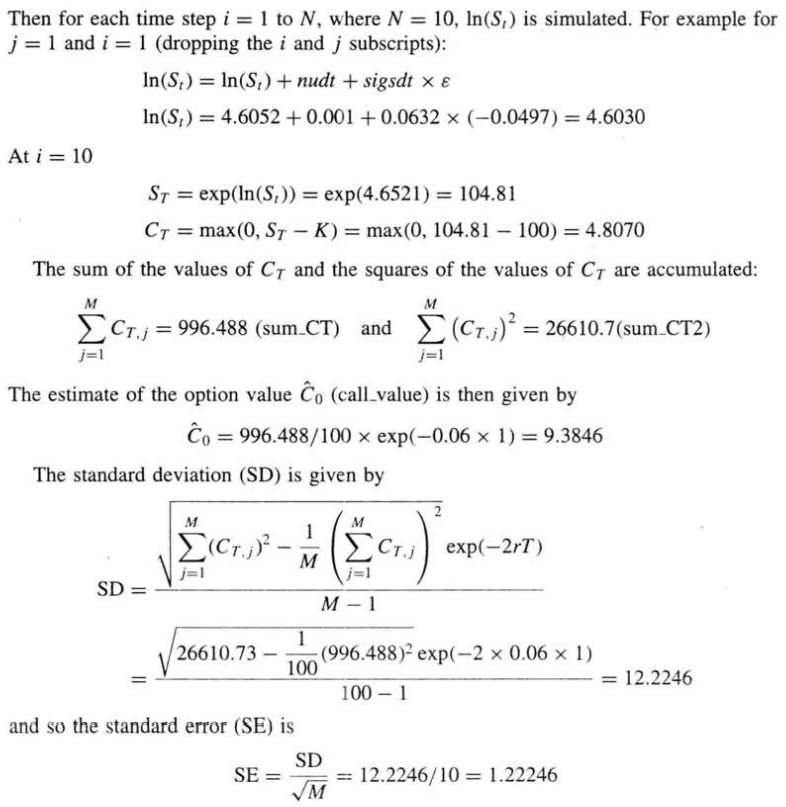

In [2]:
def monte_carlo(K,T,M,S,sig,r,div,N):
    dt = T/N # step size
    nudt = (r-div-0.5*sig**2)*dt # drift (expected return designated by Greek letter mu), average daily return υ annualized for time change dt,
                                 #under the risk-neutral probability measure, the drift of stock price μ
                                 #becomes the risk-free interest rate r (minus dividend)
    sigsdt = sig*np.sqrt(dt) # volatility of the asset (the standard deviation) per time change
    lnS = np.log(S) #normal dist
    
    # Monte carlo 
    sum_CT = 0 #st. error placeholder
    sum_CT2 = 0 #st. error placeholder
    for j in range(M):
        lnSt = lnS
        for i in range(N):
            lnSt = lnSt + nudt + sigsdt * np.random.normal() # random variable z, or the change dz is Wiener or Brownian motion process

        ST = np.exp(lnSt)
        CT = max(0, ST - K)
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT
#        For vectorized implementation use:
#     Z = np.random.normal(size=(N, M)) 
#     delta_lnSt = nudt + volsdt*Z 
#     lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
#     lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

    call_value = np.exp(-r*T)*sum_CT/M
    SD = np.sqrt(( sum_CT2 - sum_CT * sum_CT / M) * np.exp(-2 * r * T) / (M-1))
    SE = SD/np.sqrt(M)
    return call_value, SE
  

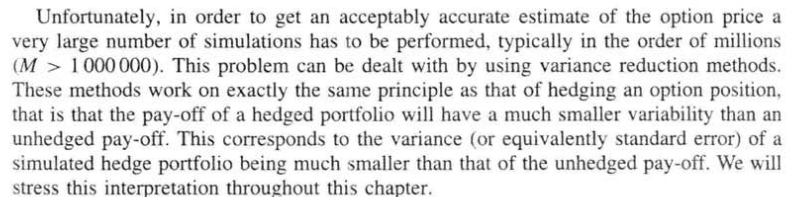

## Pseudo code for Monte Carlo Valuation of a European Call Option in a Black Schole World with Antithetic Variance Reduction
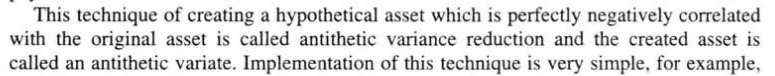

In [3]:
def monte_carlo_antithetic_var_reduction(K,T,M,S,sig,r,div,N):
    dt = T/N # step size
    nudt = (r-div-0.5*sig**2)*dt #  
    sigsdt = sig*np.sqrt(dt)
    lnS = np.log(S) #normal dist
    
    # Monte carlo 
    sum_CT = 0 #st. error placeholder
    sum_CT2 = 0 #st. error placeholder
    for j in range(M):
        lnSt1 = lnS
        lnSt2 = lnS
        for i in range(N):
            lnSt1 = lnSt1 + nudt + sigsdt * np.random.normal()
            lnSt2 = lnSt2 + nudt + sigsdt * -np.random.normal() # simulate options pay offs on the perf. negatively correlated asset by adding a minus 
                                                                # to the error term, 2 these 2 are exactly neg. correlated

        ST1 = np.exp(lnSt1)
        ST2 = np.exp(lnSt2)
        CT = (0.5*max(0, ST1 - K)) + (0.5*max(0, ST2 - K ))
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT


    call_value_A = np.exp(-r*T)*sum_CT/M
    SD = np.sqrt(( sum_CT2 - sum_CT * sum_CT / M) * np.exp(-2 * r * T) / (M-1))
    SE_A = SD/np.sqrt(M)
    return call_value_A, SE_A

In [4]:
K = 100
S = 100
T = 1
r = 0.06
N = 3
u = 1.1
d = 1/u
M = 100000
sig = 0.2
div = 0.03
for i in range(2):
    print(i)
    print(monte_carlo(K,T,M,S,sig,r,div,N))
    print(monte_carlo_antithetic_var_reduction(K,T,M,S,sig,r,div,N))

0
(9.184336084391468, 0.04330232476664469)
(9.10791373243917, 0.030504627621252542)
1
(9.177570078888364, 0.04343930198923111)
(9.087553883237758, 0.03059967485359393)


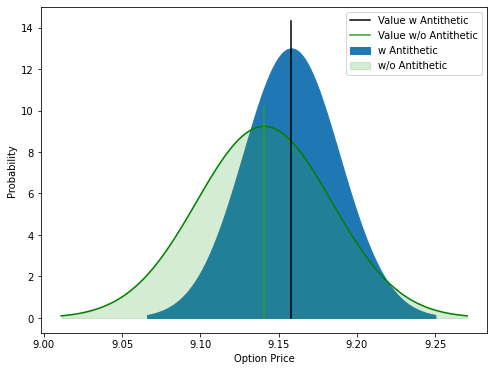

In [5]:
call_value, SE  = monte_carlo(K,T,M,S,sig,r,div,N)
call_value_A, SE_A  = monte_carlo_antithetic_var_reduction(K,T,M,S,sig,r,div,N)

plt.figure(figsize=(8, 6))
x1 = np.linspace(call_value_A-3*SE_A, call_value_A+3*SE_A, 100)
xw = np.linspace(call_value-3*SE, call_value+3*SE, 100)
s1 = stats.norm.pdf(x1, call_value_A, SE_A)
sw = stats.norm.pdf(xw, call_value, SE)
plt.fill_between(x1, s1, color='tab:blue',label='w Antithetic')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')
plt.plot([call_value_A,call_value_A],[0, max(s1)*1.1], 'k',
        label='Value w Antithetic')
plt.plot([call_value,call_value],[0, max(sw)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()